In [86]:
import torch
import numpy as np

In [87]:
a=torch.tensor([1,2],device=torch.device("cuda:0"))

In [88]:
!nvidia-smi

Tue Mar  1 06:31:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    62W / 149W |    904MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [89]:
a.device

device(type='cuda', index=0)

In [90]:
torch.cuda.is_available()

True

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

In [92]:
class Encoder(nn.Module):
  def __init__(self,capacity=64):
    super(Encoder,self).__init__()
    self.c=capacity
    self.conv1=nn.Conv2d(in_channels=1,out_channels=self.c,kernel_size=4,stride=2,padding=1)
    self.conv2=nn.Conv2d(in_channels=self.c,out_channels=self.c*2,kernel_size=4,stride=2,padding=1)
    self.mu=nn.Linear(in_features=self.c*2*7*7,out_features=6)
    self.logvar=nn.Linear(in_features=self.c*2*7*7,out_features=6)
    self.relu=nn.ReLU()
    self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.optimizer=optim.Adam(self.parameters(),lr=1e-3)
    self.to(self.device)

  def forward(self,x):
    x=self.relu(self.conv1(x))
    x=self.relu(self.conv2(x))
    x=torch.flatten(x,1)
    
    mu=self.mu(x)
    logvar=self.logvar(x)

    return mu,logvar

In [93]:
encoder=Encoder()
x=torch.rand(64,1,28,28,device=encoder.device)
mu,log_var=encoder(x)

In [94]:
class Decoder(nn.Module):
  def __init__(self, capacity=64):
    super(Decoder, self).__init__()
    self.c = capacity
    self.upsample = nn.Linear(in_features=6, out_features=self.c*2*7*7)
    self.deconv2 = nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=4, stride=2, padding=1)
    self.deconv1 = nn.ConvTranspose2d(in_channels=self.c, out_channels=1, kernel_size=4, stride=2, padding=1)
    self.relu = nn.ReLU()
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
    self.optimizer=optim.Adam(self.parameters(),lr=1e-3)
    self.to(self.device)
  def forward(self,x):
    x=self.upsample(x)
    x=nn.Unflatten(1,(self.c*2,7,7))(x)
    x=self.relu(self.deconv2(x))
    x=torch.sigmoid(self.deconv1(x))
    return x

In [95]:
decoder=Decoder()
x=torch.rand((64,6),device=decoder.device)
image=decoder(x)

In [96]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()
    self.encoder=Encoder()
    self.decoder=Decoder()
    self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.optimizer=optim.Adam(self.parameters(),lr=1e-3)
    self.to(self.device)
  def forward(self,x):
    mu,logvar=self.encoder(x)
    if self.training:
      std=logvar.mul(0.5).exp()
      dist=Normal(mu,std)
      latent_vec=dist.rsample()
    else:
      latent_vec=mu
    image=self.decoder(latent_vec)
    return image,mu,logvar

In [97]:
vae=VAE()
x=torch.randn((64,1,28,28),device=decoder.device)
image,_,_=vae(x)
print(image.shape)

torch.Size([64, 1, 28, 28])


In [98]:
def vae_loss(recon_image,in_image,mu,logvar,beta):
  recon_loss=F.binary_cross_entropy(recon_image.view(-1,784),in_image.view(-1,784),reduction="sum")
  kldivergence=-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
  return recon_loss+kldivergence

In [99]:
from torchvision .datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [100]:
img_tranforms=transforms.Compose([transforms.ToTensor()])

train_dataset=MNIST(root="./data/MNIST",download=True,train=True,transform=img_tranforms)
train_dataloader=DataLoader(dataset=train_dataset,batch_size=128,shuffle=True)

test_dataset=MNIST(root="./data/MNIST",download=True,train=False,transform=img_tranforms)
test_dataloader=DataLoader(dataset=test_dataset,batch_size=128,shuffle=True)

In [101]:
vae=VAE()
vae.train()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs=50
train_loss_avg=[]
for e in range(epochs):
  for image_in,label in train_dataloader:
    image_in=image_in.to(device)
    image_recon,mu,logvar=vae(image_in)
    loss=vae_loss(image_recon,image_in,mu,logvar,1)
    vae.optimizer.zero_grad()
    loss.backward()
    vae.optimizer.step()
  train_loss_avg.append(loss.item())
  print("loss at epoch [ %d/50 ] is %f" %(e+1,train_loss_avg[-1]))  

loss at epoch [ 1/50 ] is 13280.901367
loss at epoch [ 2/50 ] is 11298.255859
loss at epoch [ 3/50 ] is 11659.113281
loss at epoch [ 4/50 ] is 12182.284180
loss at epoch [ 5/50 ] is 11128.968750
loss at epoch [ 6/50 ] is 12213.484375
loss at epoch [ 7/50 ] is 11089.991211
loss at epoch [ 8/50 ] is 11498.660156
loss at epoch [ 9/50 ] is 11175.118164
loss at epoch [ 10/50 ] is 11803.197266
loss at epoch [ 11/50 ] is 10990.868164
loss at epoch [ 12/50 ] is 11148.708984
loss at epoch [ 13/50 ] is 11054.929688
loss at epoch [ 14/50 ] is 11143.140625
loss at epoch [ 15/50 ] is 11472.737305
loss at epoch [ 16/50 ] is 10904.987305
loss at epoch [ 17/50 ] is 10801.394531
loss at epoch [ 18/50 ] is 11209.953125
loss at epoch [ 19/50 ] is 10974.606445
loss at epoch [ 20/50 ] is 10481.092773
loss at epoch [ 21/50 ] is 10476.852539
loss at epoch [ 22/50 ] is 10784.219727
loss at epoch [ 23/50 ] is 10398.702148
loss at epoch [ 24/50 ] is 10886.896484
loss at epoch [ 25/50 ] is 10798.602539
loss at e

Text(0, 0.5, 'loss')

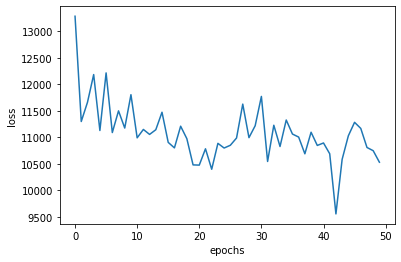

In [102]:
import matplotlib.pyplot as plt
plt.plot(train_loss_avg)
plt.xlabel("epochs")
plt.ylabel("loss")

Original images


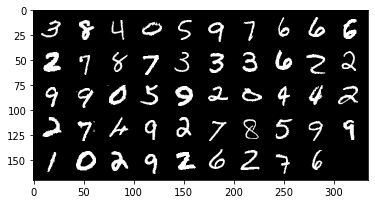

VAE reconstruction:


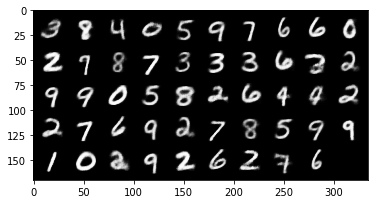

In [103]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)